*Python Machine Learning 3rd Edition* by [Sebastian Raschka](https://sebastianraschka.com) & [Vahid Mirjalili](http://vahidmirjalili.com), Packt Publishing Ltd. 2019

Code Repository: https://github.com/rasbt/python-machine-learning-book-3rd-edition

Code License: [MIT License](https://github.com/rasbt/python-machine-learning-book-3rd-edition/blob/master/LICENSE.txt)

# Chapter 17: Generative Adversarial Networks (Optional, DCGAN)

Note that the optional watermark extension is a small IPython notebook plugin that I developed to make the code reproducible. You can just skip the following line(s).

In [12]:
%load_ext watermark
%watermark -a "Sebastian Raschka & Vahid Mirjalili" -u -d -p numpy,scipy,matplotlib,tensorflow,tensorflow_datasets

Sebastian Raschka & Vahid Mirjalili 
last updated: 2019-11-04 

numpy 1.17.3
scipy 1.3.1
matplotlib 3.1.1
tensorflow 2.0.0
tensorflow_datasets 1.2.0


In [14]:
from IPython.display import Image
%matplotlib inline

In [1]:
## For running on Google-Colab
# ! pip install -q tensorflow-gpu==2.0.0

In [2]:
# from google.colab import drive
# drive.mount('/content/drive/')

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
print(tf.__version__)

print("GPU Available:", tf.test.is_gpu_available())

if tf.test.is_gpu_available():
    device_name = tf.test.gpu_device_name()

else:
    device_name = 'cpu:0'
    
print(device_name)

2.0.0
GPU Available: False
cpu:0


 * **Defining the generator and discriminator networks**

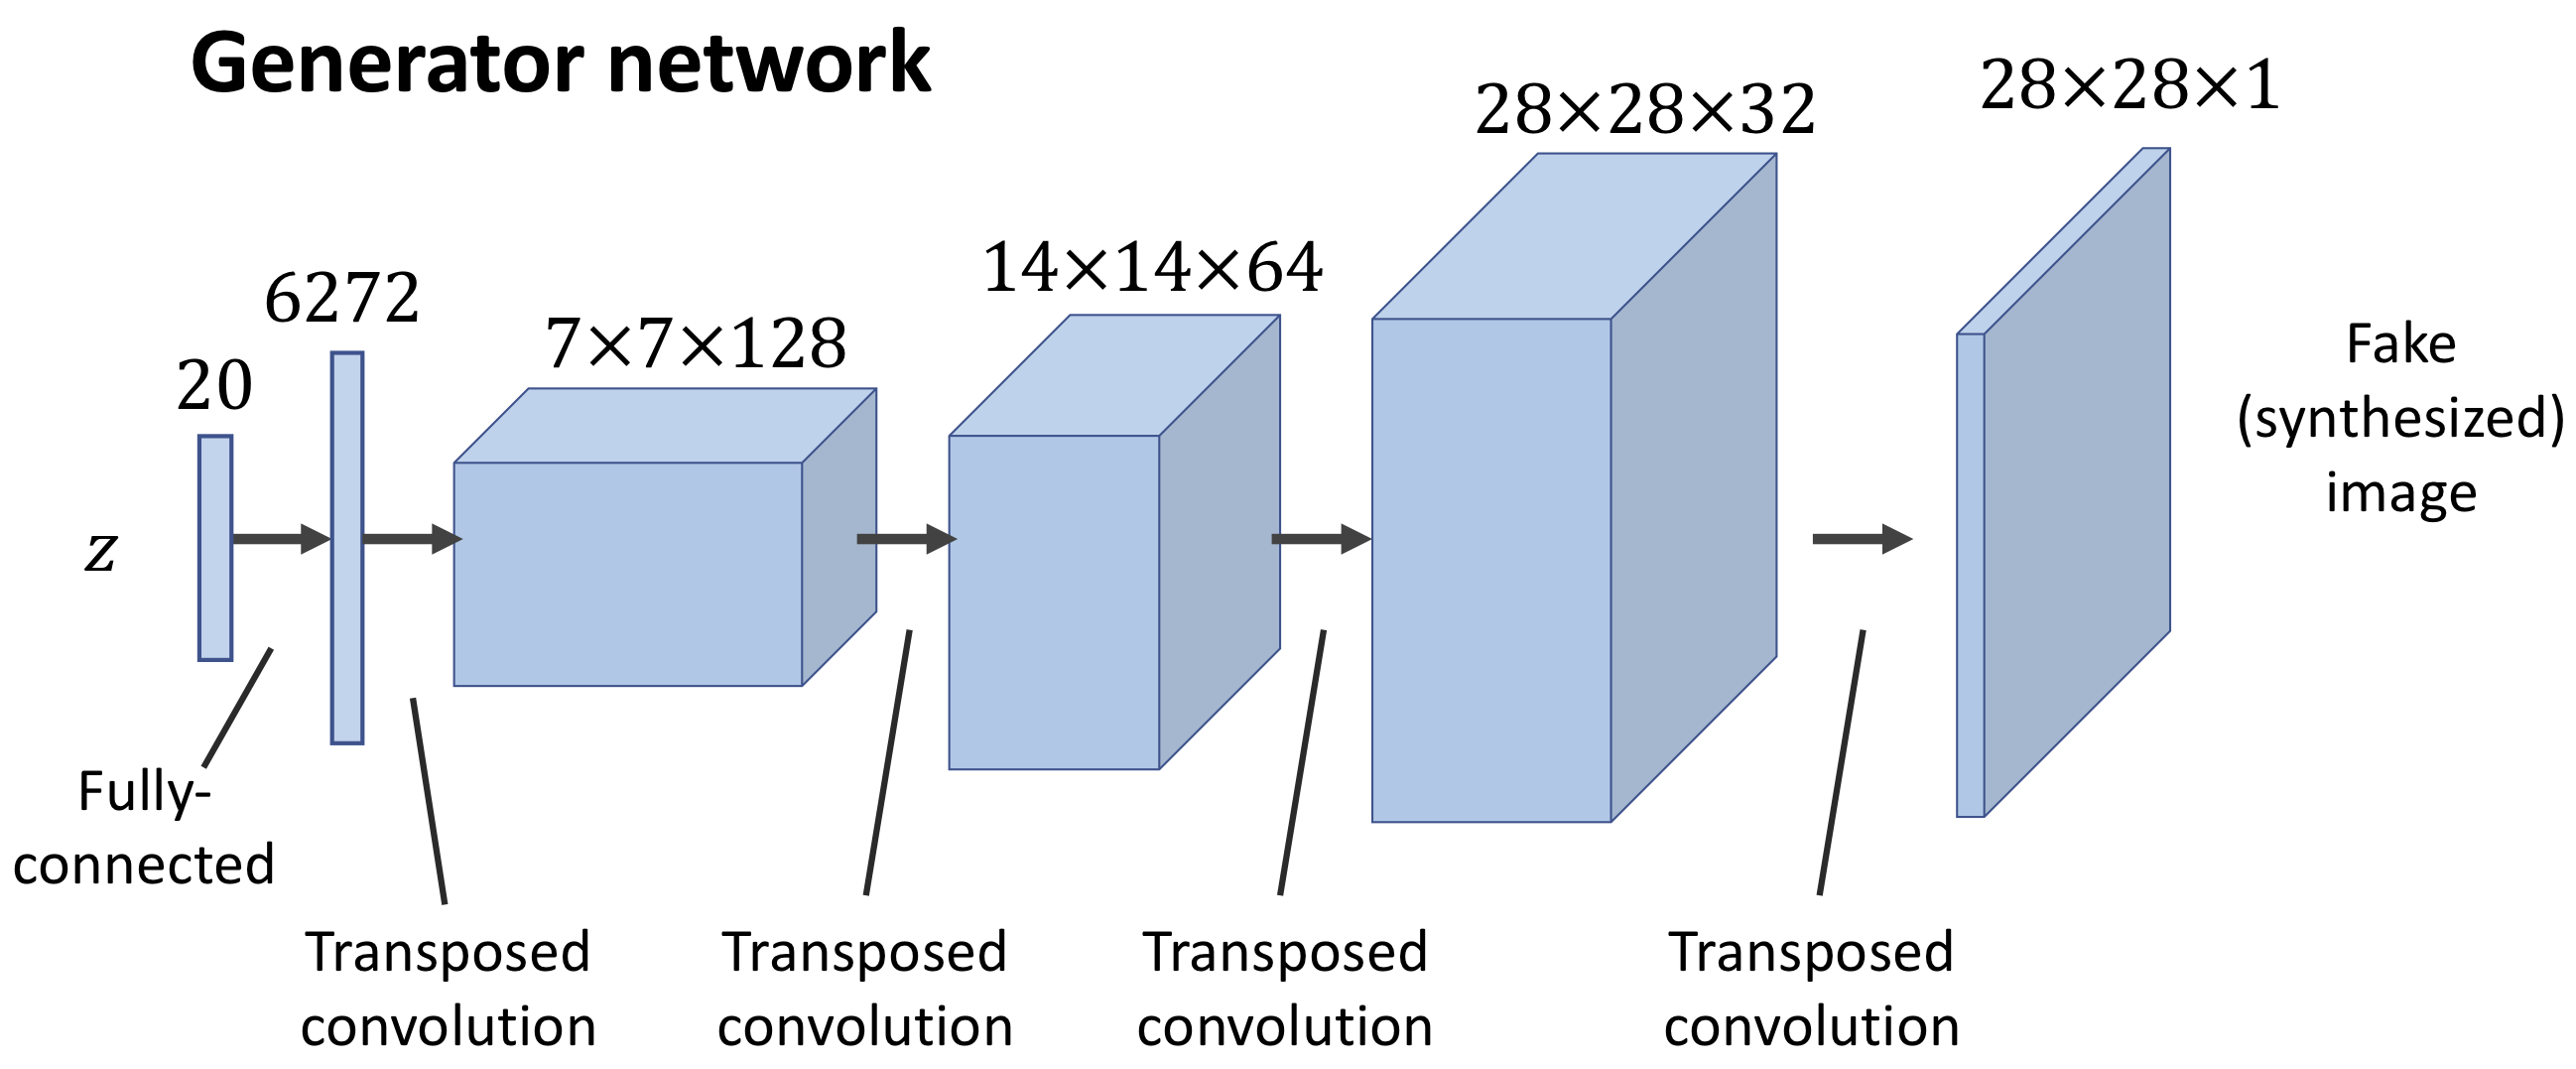

In [15]:
Image(filename='images/17_12.png', width=700)


def make_dcgan_generator(
        z_size=20, 
        output_size=(28, 28, 1),
        n_filters=64, 
        n_blocks=2):
    size_factor = 2**n_blocks
    hidden_size = (
        output_size[0]//size_factor, 
        output_size[1]//size_factor
    )
    
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(z_size,)),
        
        tf.keras.layers.Dense(
            units=n_filters*np.prod(hidden_size), 
            use_bias=False),
        
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.LeakyReLU(),
        tf.keras.layers.Reshape(
                (hidden_size[0], hidden_size[1], n_filters)),
    
        tf.keras.layers.Conv2DTranspose(
            filters=n_filters, kernel_size=(3, 3), strides=(1, 1),
            padding='same', use_bias=False),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.LeakyReLU()
    ])
        
    nf = n_filters
    for i in range(n_blocks):
        nf = nf // 2
        model.add(
            tf.keras.layers.Conv2DTranspose(
                filters=nf, kernel_size=(3, 3), strides=(2, 2),
                padding='same', use_bias=False))
        
        model.add(tf.keras.layers.BatchNormalization())
        
        model.add(tf.keras.layers.LeakyReLU())
                
    model.add(
        tf.keras.layers.Conv2DTranspose(
            filters=output_size[2], kernel_size=(5, 5), 
            strides=(1, 1), padding='same', use_bias=True, 
            activation='tanh'))
        
    return model

In [14]:
def make_dcgan_generator(
        z_size=100, 
        output_size=(28, 28, 1),
        n_filters=64):
    
    hidden_size = (7, 7)
    
    model = tf.keras.Sequential()
    
    # 100 ==> 784 ==> 7x7x64
    model.add(tf.keras.layers.Dense(
        units=n_filters*np.prod(hidden_size), use_bias=False)
    )
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU(alpha=0.0001))
    
    print(model.compute_output_shape((None, z_size)))

    model.add(tf.keras.layers.Reshape(
        target_shape=(hidden_size[0], hidden_size[1], n_filters))
    )
    
    print(model.compute_output_shape((None, z_size)))

    # 7x7x64 ==> 14*14*32
    model.add(tf.keras.layers.Conv2DTranspose(
        filters=n_filters//2, kernel_size=(3, 3), strides=(2, 2),
        padding='same', use_bias=False, activation=None)
    )
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU(alpha=0.0001))
    model.add(tf.keras.layers.Dropout(0.5))
    
    print(model.compute_output_shape((None, z_size)))
    
    # 14x14x32 ==> 28x28x16
    model.add(tf.keras.layers.Conv2DTranspose(
        filters=n_filters//4, kernel_size=(3, 3), strides=(2, 2),
        padding='same', use_bias=False, activation=None)
    )
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU(alpha=0.0001))
    model.add(tf.keras.layers.Dropout(0.5))

    print(model.compute_output_shape((None, z_size)))
    
    # 28x28x16 ==> 28x28x8
    model.add(tf.keras.layers.Conv2DTranspose(
        filters=n_filters//8, kernel_size=(3, 3), strides=(1, 1),
        padding='same', use_bias=False, activation=None)
    )
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU(alpha=0.0001))
    model.add(tf.keras.layers.Dropout(0.5))

    print(model.compute_output_shape((None, z_size)))

    # 28x28x8 ==> 28x28x1
    model.add(tf.keras.layers.Conv2DTranspose(
        filters=1, kernel_size=(3, 3), strides=(1, 1),
        padding='same', use_bias=False, activation='tanh')
    )

    print(model.compute_output_shape((None, z_size)))

    return model

In [15]:
gen_model = make_dcgan_generator()
gen_model.build(input_shape=(None, 20))
gen_model.summary()

(None, 3136)
(None, 7, 7, 64)
(None, 14, 14, 32)
(None, 28, 28, 16)
(None, 28, 28, 8)
(None, 28, 28, 1)
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              multiple                  62720     
_________________________________________________________________
batch_normalization_17 (Batc multiple                  12544     
_________________________________________________________________
leaky_re_lu_15 (LeakyReLU)   multiple                  0         
_________________________________________________________________
reshape_4 (Reshape)          multiple                  0         
_________________________________________________________________
conv2d_transpose_14 (Conv2DT multiple                  18432     
_________________________________________________________________
batch_normalization_18 (Batc multiple                  128       
________________

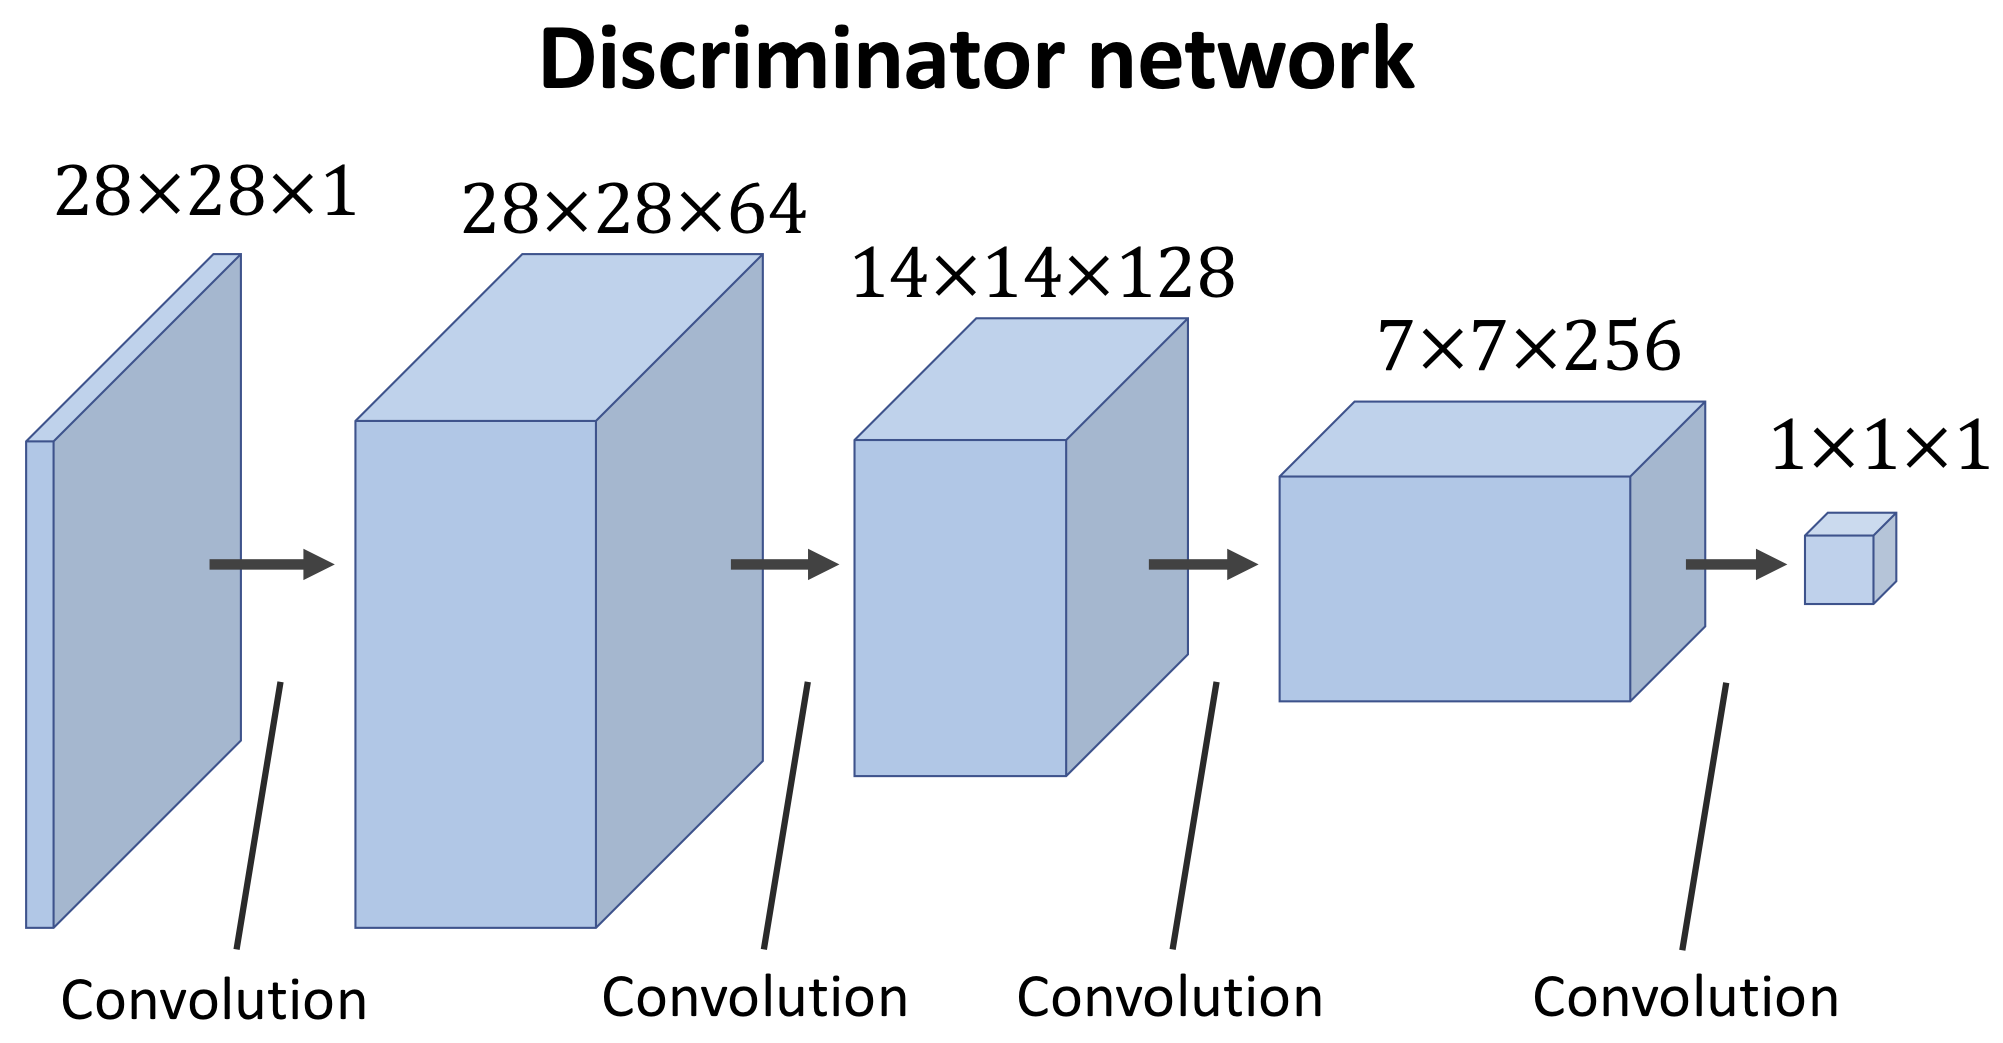

In [18]:
Image(filename='images/17_13.png', width=700)





def make_dcgan_discriminator(
        input_size=(28, 28, 1),
        n_filters=16, 
        n_blocks=2):
    
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Input(shape=input_size))
    #    [tf.keras.layers.Input(shape=input_size),
    #    tf.keras.layers.Conv2D(
    #        filters=n_filters, kernel_size=5, 
    #        strides=(2, 2), padding='same', use_bias=False),
    #    tf.keras.layers.BatchNormalization(),
    ##    tf.keras.layers.LeakyReLU(),
    #    model.add(tf.keras.layers.Dropout(0.5)
    #])
    
    nf = n_filters
    for i in range(n_blocks):
        model.add(
            tf.keras.layers.Conv2D(
                filters=nf, kernel_size=(3, 3), 
                strides=(2, 2),padding='same', use_bias=False))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.LeakyReLU())
        model.add(tf.keras.layers.Dropout(0.5))
        nf = nf*2
        
    model.add(tf.keras.layers.Conv2D(
              filters=1, kernel_size=(7, 7), padding='valid',
              use_bias=True, activation=None))
    
    model.add(tf.keras.layers.Reshape((1,)))
    
    return model

In [23]:
def make_dcgan_discriminator(
        input_size=(28, 28, 1),
        n_filters=64):
    
    hidden_size = (7, 7)
    
    model = tf.keras.Sequential()
    
    model.add(tf.keras.layers.Reshape(
        target_shape=(input_size[0], input_size[1], input_size[2]))
    )
    print(model.compute_output_shape((None, *input_size)))

    # 7x7x64 ==> 14*14*32
    model.add(tf.keras.layers.Conv2D(
        filters=n_filters//8, kernel_size=(3, 3), strides=(2, 2),
        padding='same', use_bias=False, activation=None)
    )
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU(alpha=0.0001))
    model.add(tf.keras.layers.Dropout(0.5))
    
    print(model.compute_output_shape((None, *input_size)))
    
    # 14x14x32 ==> 28x28x16
    model.add(tf.keras.layers.Conv2D(
        filters=n_filters//2, kernel_size=(3, 3), strides=(2, 2),
        padding='same', use_bias=False, activation=None)
    )
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU(alpha=0.0001))
    model.add(tf.keras.layers.Dropout(0.5))

    print(model.compute_output_shape((None, *input_size)))

    model.add(tf.keras.layers.Reshape(
        target_shape=(np.prod([input_size[0]//4, input_size[1]//4, n_filters//2]),))
    )
    
    print(model.compute_output_shape((None, *input_size)))
    
    model.add(tf.keras.layers.Dense(
        units=1, use_bias=False)
    )

    print(model.compute_output_shape((None, *input_size)))

    return model

In [25]:


disc_model = make_dcgan_discriminator()
disc_model.build(input_shape=(None, 28, 28, 1))
disc_model.summary()

(None, 28, 28, 1)
(None, 14, 14, 8)
(None, 7, 7, 32)
(None, 1568)
(None, 1)
Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_12 (Reshape)         multiple                  0         
_________________________________________________________________
conv2d_7 (Conv2D)            multiple                  72        
_________________________________________________________________
batch_normalization_28 (Batc multiple                  32        
_________________________________________________________________
leaky_re_lu_26 (LeakyReLU)   multiple                  0         
_________________________________________________________________
dropout_20 (Dropout)         multiple                  0         
_________________________________________________________________
conv2d_8 (Conv2D)            multiple                  2304      
___________________________________________

* **Loading and preprocessing the data**

In [26]:
mnist_bldr = tfds.builder('mnist')
mnist_bldr.download_and_prepare()
mnist = mnist_bldr.as_dataset(shuffle_files=False)

def preprocess(ex, mode='uniform'):
    image = ex['image']
    image = tf.image.convert_image_dtype(image, tf.float32)

    image = image*2 - 1.0
    
    if mode == 'uniform':
        input_z = tf.random.uniform(shape=(z_size,),
                                    minval=-1.0, maxval=1.0)
    elif mode == 'normal':
        input_z = tf.random.normal(shape=(z_size,))
    return input_z, image


In [29]:

num_epochs = 100
batch_size = 64
image_size = (28, 28)
z_size = 20
mode_z = 'uniform'
#gen_hidden_layers = 1
#gen_hidden_size = 100
#disc_hidden_layers = 1
#disc_hidden_size = 100

tf.random.set_seed(1)
np.random.seed(1)


if mode_z == 'uniform':
    fixed_z = tf.random.uniform(
        shape=(batch_size, z_size),
        minval=-1, maxval=1)
elif mode_z == 'normal':
    fixed_z = tf.random.normal(
        shape=(batch_size, z_size))


def create_samples(g_model, input_z):
    g_output = g_model(input_z, training=False)
    images = tf.reshape(g_output, (batch_size, *image_size))    
    return (images+1)/2.0

## Set-up the dataset
mnist_trainset = mnist['train']
mnist_trainset = mnist_trainset.map(
    lambda ex: preprocess(ex, mode=mode_z))

mnist_trainset = mnist_trainset.shuffle(10000)
mnist_trainset = mnist_trainset.batch(
    batch_size, drop_remainder=True)



* **Final Training**

In [30]:
import time

## Set-up the model
with tf.device(device_name):
    gen_model = make_dcgan_generator()
    disc_model = make_dcgan_discriminator()


## Loss function and optimizers:
loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=True)
g_optimizer = tf.keras.optimizers.Adam()
d_optimizer = tf.keras.optimizers.Adam()

all_losses = []
all_d_vals = []
epoch_samples = []

start_time = time.time()
for epoch in range(1, num_epochs+1):
    epoch_losses, epoch_d_vals = [], []
    for i,(input_z,input_real) in enumerate(mnist_trainset): #.take(4)
        
        ## Compute generator's loss
        with tf.GradientTape() as g_tape:
            g_output = gen_model(input_z)
            d_logits_fake = disc_model(g_output, training=True)
            
            g_loss = loss_fn(y_true=tf.ones_like(d_logits_fake),
                             y_pred=d_logits_fake)
            
        ## > Compute the gradients of g_loss
        g_grads = g_tape.gradient(g_loss, gen_model.trainable_variables)
        g_optimizer.apply_gradients(
            grads_and_vars=zip(g_grads, gen_model.trainable_variables))

        
        ## Compute discriminator's loss
        with tf.GradientTape() as d_tape:
            d_logits_real = disc_model(input_real, training=True)

            d_logits_fake = disc_model(g_output, training=True)

            d_loss_real = loss_fn(y_true=tf.ones_like(d_logits_real),
                                  y_pred=d_logits_real)
            
            d_loss_fake = loss_fn(y_true=tf.zeros_like(d_logits_fake),
                                  y_pred=d_logits_fake)

            d_loss = d_loss_real + d_loss_fake

        ##  > Compute the gradients of d_loss
        d_grads = d_tape.gradient(d_loss, disc_model.trainable_variables)
        d_optimizer.apply_gradients(
            grads_and_vars=zip(d_grads, disc_model.trainable_variables))
                           
        epoch_losses.append(
            (g_loss.numpy(), d_loss.numpy(), 
             d_loss_real.numpy(), d_loss_fake.numpy()))
        
        d_probs_real = tf.reduce_mean(tf.sigmoid(d_logits_real))
        d_probs_fake = tf.reduce_mean(tf.sigmoid(d_logits_fake))
        epoch_d_vals.append((d_probs_real.numpy(), d_probs_fake.numpy()))        
    all_losses.append(epoch_losses)
    all_d_vals.append(epoch_d_vals)
    print(
        'Epoch {:03d} | ET {:.2f} min | Avg Losses >>'
        ' G/D {:.4f}/{:.4f} [D-Real: {:.4f} D-Fake: {:.4f}]'
        .format(
            epoch, (time.time() - start_time)/60, 
            *list(np.mean(all_losses[-1], axis=0))))
    epoch_samples.append(
        create_samples(gen_model, fixed_z).numpy())

(None, 3136)
(None, 7, 7, 64)
(None, 14, 14, 32)
(None, 28, 28, 16)
(None, 28, 28, 8)
(None, 28, 28, 1)
(None, 28, 28, 1)
(None, 14, 14, 8)
(None, 7, 7, 32)
(None, 1568)
(None, 1)
Epoch 001 | ET 0.02 min | Avg Losses >> G/D 0.9679/1.8191 [D-Real: 0.9502 D-Fake: 0.8689]
Epoch 002 | ET 0.05 min | Avg Losses >> G/D 0.8301/1.7114 [D-Real: 0.5024 D-Fake: 1.2090]
Epoch 003 | ET 0.08 min | Avg Losses >> G/D 0.7296/1.4192 [D-Real: 0.5160 D-Fake: 0.9032]
Epoch 004 | ET 0.10 min | Avg Losses >> G/D 0.7307/1.2728 [D-Real: 0.4649 D-Fake: 0.8079]
Epoch 005 | ET 0.13 min | Avg Losses >> G/D 0.8306/1.4187 [D-Real: 0.5127 D-Fake: 0.9059]
Epoch 006 | ET 0.16 min | Avg Losses >> G/D 0.7892/1.2391 [D-Real: 0.5841 D-Fake: 0.6550]
Epoch 007 | ET 0.18 min | Avg Losses >> G/D 1.0004/1.2078 [D-Real: 0.4549 D-Fake: 0.7530]
Epoch 008 | ET 0.21 min | Avg Losses >> G/D 0.8834/1.1440 [D-Real: 0.4708 D-Fake: 0.6732]
Epoch 009 | ET 0.24 min | Avg Losses >> G/D 1.1597/1.1740 [D-Real: 0.4377 D-Fake: 0.7363]
Epoch 010 

Epoch 091 | ET 2.31 min | Avg Losses >> G/D 1.2233/1.2756 [D-Real: 0.5037 D-Fake: 0.7719]
Epoch 092 | ET 2.34 min | Avg Losses >> G/D 1.4475/1.3191 [D-Real: 0.6401 D-Fake: 0.6790]
Epoch 093 | ET 2.37 min | Avg Losses >> G/D 1.9619/1.5093 [D-Real: 0.8096 D-Fake: 0.6997]
Epoch 094 | ET 2.39 min | Avg Losses >> G/D 1.6718/1.3646 [D-Real: 0.8153 D-Fake: 0.5493]
Epoch 095 | ET 2.42 min | Avg Losses >> G/D 1.4617/1.1160 [D-Real: 0.6126 D-Fake: 0.5034]
Epoch 096 | ET 2.44 min | Avg Losses >> G/D 1.3098/1.5227 [D-Real: 0.8559 D-Fake: 0.6667]
Epoch 097 | ET 2.47 min | Avg Losses >> G/D 0.9726/1.0533 [D-Real: 0.5013 D-Fake: 0.5520]
Epoch 098 | ET 2.50 min | Avg Losses >> G/D 1.1679/1.4432 [D-Real: 0.6131 D-Fake: 0.8301]
Epoch 099 | ET 2.53 min | Avg Losses >> G/D 1.7074/1.4044 [D-Real: 0.7453 D-Fake: 0.6590]
Epoch 100 | ET 2.55 min | Avg Losses >> G/D 1.5163/1.2579 [D-Real: 0.6500 D-Fake: 0.6079]


In [ ]:
#import pickle
#pickle.dump({'all_losses':all_losses, 
#             'all_d_vals':all_d_vals,
#             'samples':epoch_samples}, 
#             open('/content/drive/My Drive/Colab Notebooks/PyML-3rd-edition/ch17-dcgan-learning.pkl', 'wb'))

#gen_model.save('/content/drive/My Drive/Colab Notebooks/PyML-3rd-edition/ch17-dcgangan_gen.h5')
#disc_model.save('/content/drive/My Drive/Colab Notebooks/PyML-3rd-edition/ch17-dcgan_disc.h5')

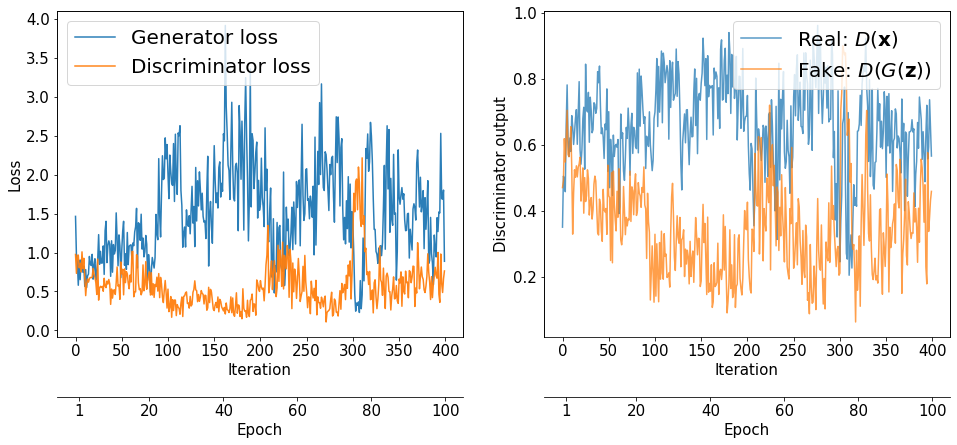

In [31]:
import itertools


fig = plt.figure(figsize=(16, 6))

## Plotting the losses
ax = fig.add_subplot(1, 2, 1)
g_losses = [item[0] for item in itertools.chain(*all_losses)]
d_losses = [item[1]/2.0 for item in itertools.chain(*all_losses)]
plt.plot(g_losses, label='Generator loss', alpha=0.95)
plt.plot(d_losses, label='Discriminator loss', alpha=0.95)
plt.legend(fontsize=20)
ax.set_xlabel('Iteration', size=15)
ax.set_ylabel('Loss', size=15)

epochs = np.arange(1, 101)
epoch2iter = lambda e: e*len(all_losses[-1])
epoch_ticks = [1, 20, 40, 60, 80, 100]
newpos = [epoch2iter(e) for e in epoch_ticks]
ax2 = ax.twiny()
ax2.set_xticks(newpos)
ax2.set_xticklabels(epoch_ticks)
ax2.xaxis.set_ticks_position('bottom')
ax2.xaxis.set_label_position('bottom')
ax2.spines['bottom'].set_position(('outward', 60))
ax2.set_xlabel('Epoch', size=15)
ax2.set_xlim(ax.get_xlim())
ax.tick_params(axis='both', which='major', labelsize=15)
ax2.tick_params(axis='both', which='major', labelsize=15)

## Plotting the outputs of the discriminator
ax = fig.add_subplot(1, 2, 2)
d_vals_real = [item[0] for item in itertools.chain(*all_d_vals)]
d_vals_fake = [item[1] for item in itertools.chain(*all_d_vals)]
plt.plot(d_vals_real, alpha=0.75, label=r'Real: $D(\mathbf{x})$')
plt.plot(d_vals_fake, alpha=0.75, label=r'Fake: $D(G(\mathbf{z}))$')
plt.legend(fontsize=20)
ax.set_xlabel('Iteration', size=15)
ax.set_ylabel('Discriminator output', size=15)

ax2 = ax.twiny()
ax2.set_xticks(newpos)
ax2.set_xticklabels(epoch_ticks)
ax2.xaxis.set_ticks_position('bottom')
ax2.xaxis.set_label_position('bottom')
ax2.spines['bottom'].set_position(('outward', 60))
ax2.set_xlabel('Epoch', size=15)
ax2.set_xlim(ax.get_xlim())
ax.tick_params(axis='both', which='major', labelsize=15)
ax2.tick_params(axis='both', which='major', labelsize=15)


#plt.savefig('images/ch17-dcgan-learning-curve.pdf')
plt.show()

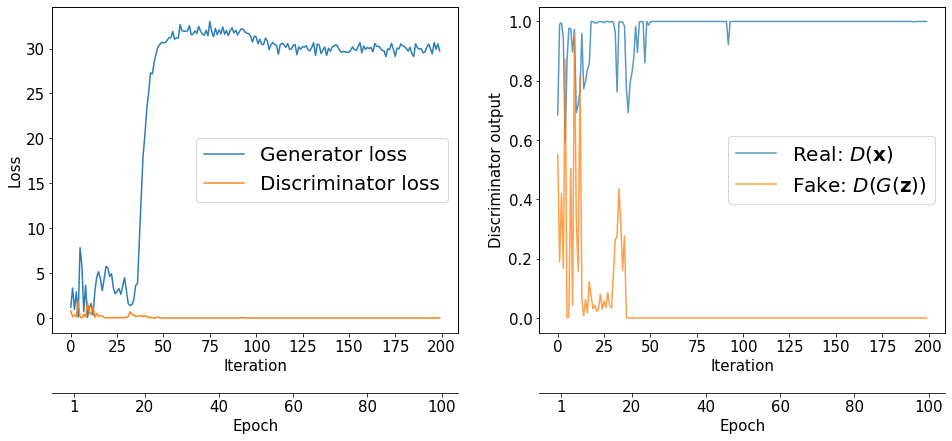

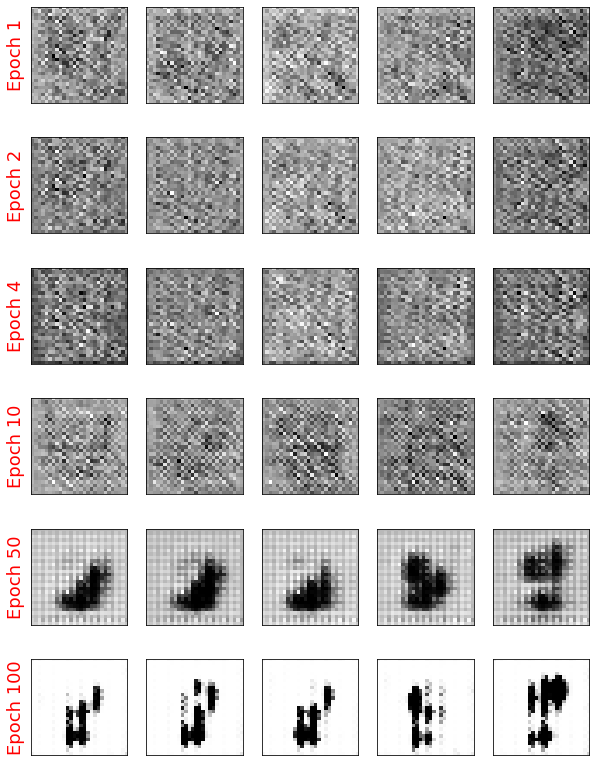

In [32]:
selected_epochs = [1, 2, 4, 10, 50, 100]
fig = plt.figure(figsize=(10, 14))
for i,e in enumerate(selected_epochs):
    for j in range(5):
        ax = fig.add_subplot(6, 5, i*5+j+1)
        ax.set_xticks([])
        ax.set_yticks([])
        if j == 0:
            ax.text(
                -0.06, 0.5, 'Epoch {}'.format(e),
                rotation=90, size=18, color='red',
                horizontalalignment='right',
                verticalalignment='center', 
                transform=ax.transAxes)
        
        image = epoch_samples[e-1][j]
        ax.imshow(image, cmap='gray_r')
    
#plt.savefig('images/ch17-dcgan-samples.pdf')
plt.show()